# 🔍 Efficient NAS-BNN Pipeline - Multi-Dataset Support

**Neural Architecture Search for Binary Neural Networks - Complete Automation Pipeline**

This notebook provides a **unified pipeline** for running NAS-BNN across **multiple datasets** with both **online and local** data preparation options.

### 📋 **Pipeline Steps:**
1. **Dataset Selection & Preparation** - Choose from ImageNet, CIFAR-10, or WakeVision
2. **OPs Range Check** - Determine valid operation ranges for the architecture
3. **Supernet Training** - Train the supernet across all possible architectures  
4. **Architecture Search** - Evolutionary search for Pareto-optimal architectures
5. **Performance Testing** - Evaluate discovered architectures
6. **Fine-tuning** - Improve performance of selected architectures
7. **Analysis & Visualization** - Comprehensive results analysis
8. **Model Export** - Export to ONNX for deployment

### 🎯 **Supported Datasets:**

| Dataset | Architecture | Image Size | Classes | Preparation Methods |
|---------|--------------|------------|---------|-------------------|
| **🌐 ImageNet** | `superbnn_imagenet` | 224×224 | 1000 | Online/Local |
| **🎯 CIFAR-10** | `superbnn_cifar10(_large)` | 32×32 | 10 | Online/Local |
| **👤 WakeVision** | `superbnn_wakevision_large` | 128×128 | 2 | Online/Local |

### 🔄 **Data Preparation Options:**
- **📡 Online**: Automatic download using torchvision, HuggingFace, or custom scripts
- **💾 Local**: Process from pre-downloaded files or custom datasets
- **🎛️ Flexible**: Switch datasets by changing configuration and running appropriate prep cell

### ⚙️ **Prerequisites:**
- **Python Environment**: Ensure the `nasbnn` environment is selected as the kernel
- **GPU Setup**: Set `CUDA_VISIBLE_DEVICES` before launching Jupyter: 
  - CMD: `set CUDA_VISIBLE_DEVICES=0`
  - PowerShell: `$env:CUDA_VISIBLE_DEVICES="0"`
- **Dependencies**: All requirements from `requirements.txt` must be installed

### 🚨 **Quick Start:**
1. **Configure**: Set `dataset_name` and `architecture_name` in Cell 2
2. **Prepare Data**: Run the appropriate dataset preparation cell
3. **Execute Pipeline**: Run remaining cells sequentially
4. **Analyze Results**: View comprehensive analysis and export models

### 💡 **Key Features:**
- **Multi-dataset Support**: Easy switching between ImageNet, CIFAR-10, and WakeVision
- **Flexible Data Prep**: Both online download and local file processing
- **Complete Automation**: Minimal manual intervention required
- **Comprehensive Analysis**: Built-in visualization and performance comparison
- **Production Ready**: ONNX export for deployment

In [1]:
import os
import subprocess
import torch 
import re 
import pandas as pd 
from IPython.display import display 
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

print("--- Initial Environment Setup and Configuration for Wake Vision ---")

# --- Configuration Variables ---
# >>>>> DATASET AND ARCHITECTURE CONFIGURATION FOR WAKE VISION <<<<<
dataset_name = "WakeVision"
architecture_name = "superbnn_wakevision_large" 
global_workers = 0 

# VVVVVV ADD THIS NEW CONFIGURATION VARIABLE VVVVVV
wakevision_img_size = 128 # Define the image size for WakeVision (e.g., 128, 96)
# This should match what prepare_wakevision.py uses for TARGET_IMAGE_SIZE
# and what superbnn_wakevision_large in models/superbnn.py expects.
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

data_path = "./data/WakeVision_From_Local_SSD_V3" # Ensure this is where prepare_wakevision.py saves data
base_work_dir = "./work_dirs/wakevision_nasbnn_LARGEXP_run" 
supernet_checkpoint_path = f"{base_work_dir}/checkpoint.pth.tar"
search_output_dir = f"{base_work_dir}/search"
search_info_file = f"{search_output_dir}/info.pth.tar"

# Supernet Training Params for Wake Vision
train_supernet_epochs = 10       
train_supernet_batch_size = 64   # You changed this to 64, which is good.
train_supernet_lr = "2.5e-3"     
train_supernet_wd = "5e-6"       

# Search Params for Wake Vision
search_max_epochs = 10           
search_population_num = 50       
search_m_prob = 0.2              
search_crossover_num = 10        
search_mutation_num = 10         
search_ops_min = 3.8             # From your previous successful check_ops for superbnn_cifar10_large. 
search_ops_max = 6.2             # For superbnn_wakevision_large, this needs to be updated after Cell 6.
search_step = 0.2                
search_max_train_iters = 10      
search_train_batch_size = 64     
search_test_batch_size = 64      

# Test Params
test_max_train_iters = 10
test_train_batch_size = 64       
test_test_batch_size = 64        
ops_key_to_test1 = 5             
ops_key_to_test2 = 6
test_img_size = 128             

# Fine-tuning Params
finetune_batch_size = 64 # You changed this from 1024, which is good.
finetune_lr = "5e-5" 
finetune_wd = 0
finetune_epochs = 50 # You changed this, also reasonable.

# --- Environment Variable Setup ---
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["PYTHONUNBUFFERED"] = "1"
print(f"INFO: Attempted to set CUDA_VISIBLE_DEVICES to: {os.environ.get('CUDA_VISIBLE_DEVICES')}")
print(f"INFO: Attempted to set PYTHONUNBUFFERED to: {os.environ.get('PYTHONUNBUFFERED')}")
print(f"INFO: Current working directory: {os.getcwd()}")
print(f"INFO: Output for this run will be in: {base_work_dir}")
print("---------------------------------")

# --- CUDA Installation and GPU Check ---
print("--- CUDA Installation and GPU Check ---")
if 'torch' not in globals(): import torch 
print(f"PyTorch version: {torch.__version__}") 
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version reported by PyTorch (torch.version.cuda): {torch.version.cuda}")
    print(f"Number of GPUs available to PyTorch: {torch.cuda.device_count()}")
    try:
        cuda_device_idx = 0 
        torch.cuda.set_device(cuda_device_idx) 
        print(f"Current PyTorch CUDA device (after setting to {cuda_device_idx}): {torch.cuda.current_device()}")
        print(f"GPU name for PyTorch cuda:{cuda_device_idx}: {torch.cuda.get_device_name(torch.cuda.current_device())}")
        print("\nAttempting a small model and tensor operation on CUDA device...")
        model_test = torch.nn.Linear(10,1).to(torch.device(f"cuda:{cuda_device_idx}"))
        if list(model_test.parameters()):
             pass
        else: print("Test model has no parameters.")
        a = torch.randn(5, 10).to(torch.device(f"cuda:{cuda_device_idx}"))
        b = model_test(a)
        print(f"Small CUDA op successful. Output sum: {b.sum().item()}")
    except Exception as e:
        print(f"Error during CUDA operations: {e}")
else:
    print("CUDA not available, cannot perform GPU tests with PyTorch CUDA backend.")

cuda_visible_devices_env = os.environ.get('CUDA_VISIBLE_DEVICES')
print(f"\nChecking environment variable CUDA_VISIBLE_DEVICES (as seen by Python os.environ):")
if cuda_visible_devices_env:
    print(f"CUDA_VISIBLE_DEVICES is set to: {cuda_visible_devices_env}")
else:
    print("CUDA_VISIBLE_DEVICES is NOT set or is empty in os.environ.")
print("---------------------------------")

# --- Helper Function for Log Parsing (used by Analysis Cells later) ---
def parse_accuracy_from_log(log_file_path):
    """Parse top-1 accuracy from log files generated by train.py, test.py, and train_single.py"""
    top1_accuracy = None
    if not os.path.exists(log_file_path):
        print(f"Warning: Log file not found at {log_file_path}")
        return None
    try:
        with open(log_file_path, 'r') as f: lines = f.readlines()
        for line in reversed(lines):
            # Pattern for test.py: "Top-1 Accuracy: 67.40% Top-5 Accuracy: 67.40% on 500 test images"
            match_test_new = re.search(r"Top-1 Accuracy: (\d+\.\d+)%", line)
            if match_test_new: top1_accuracy = float(match_test_new.group(1)); break
            
            # Pattern for old test.py format: "INFO - top1: 67.40"
            match_test_old = re.search(r"INFO - top1: (\d+\.\d+)", line)
            if match_test_old: top1_accuracy = float(match_test_old.group(1)); break
            
            # Pattern for train_single.py: "INFO -  * Acc@1 67.40"
            match_train_single = re.search(r"INFO -  \* Acc@1 (\d+\.\d+)", line)
            if match_train_single: top1_accuracy = float(match_train_single.group(1)); break
            
            # Pattern for train.py: "* Acc@1 67.40 Acc@5 67.40"
            match_train = re.search(r"\* Acc@1 (\d+\.\d+)", line)
            if match_train: top1_accuracy = float(match_train.group(1)); break
            
        if top1_accuracy is not None: print(f"Parsed accuracy {top1_accuracy:.2f}% from {os.path.basename(log_file_path)}")
        else: print(f"Warning: Could not parse Top-1 accuracy from {log_file_path}")
    except Exception as e: print(f"Error parsing log file {log_file_path}: {e}"); return None
    return top1_accuracy

os.makedirs(base_work_dir, exist_ok=True) 
print(f"INFO: Ensured base work directory exists: {base_work_dir}")
print("--- Configuration and Setup Cell Complete ---")

--- Initial Environment Setup and Configuration for Wake Vision ---
INFO: Attempted to set CUDA_VISIBLE_DEVICES to: 0
INFO: Attempted to set PYTHONUNBUFFERED to: 1
INFO: Current working directory: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09
INFO: Output for this run will be in: ./work_dirs/wakevision_nasbnn_LARGEXP_run
---------------------------------
--- CUDA Installation and GPU Check ---
PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA version reported by PyTorch (torch.version.cuda): 12.8
Number of GPUs available to PyTorch: 1
Current PyTorch CUDA device (after setting to 0): 0
GPU name for PyTorch cuda:0: NVIDIA GeForce RTX 4050 Laptop GPU

Attempting a small model and tensor operation on CUDA device...
Small CUDA op successful. Output sum: -0.6913375854492188

Checking environment variable CUDA_VISIBLE_DEVICES (as seen by Python os.environ):
CUDA_VISIBLE_DEVICES is set to: 0
---------------------------------
INFO: Ensured base work directory exists: ./

## 📊 Configuration Summary

**Current Pipeline Configuration:**

| Setting | Value | Description |
|---------|--------|-------------|
| **Dataset** | `{dataset_name}` | Currently selected dataset |
| **Architecture** | `{architecture_name}` | Compatible BNN architecture |
| **Image Size** | `{wakevision_img_size}x{wakevision_img_size}` | Input image dimensions |
| **Data Path** | `{data_path}` | Processed dataset location |
| **Work Directory** | `{base_work_dir}` | Output directory |

**Supported Datasets & Architectures:**
- **🌐 ImageNet**: `superbnn_imagenet` (224x224) - Large-scale, 1000 classes
- **🎯 CIFAR-10**: `superbnn_cifar10` or `superbnn_cifar10_large` (32x32) - 10 classes  
- **👤 WakeVision**: `superbnn_wakevision_large` (128x128) - Person detection

**Training Parameters:**
- **Supernet Epochs:** {train_supernet_epochs} (quick training for demo)
- **Search Epochs:** {search_max_epochs} (evolutionary search iterations)
- **Fine-tune Epochs:** {finetune_epochs} (dedicated training)
- **Batch Size:** {train_supernet_batch_size} (balanced for memory/performance)

**Architecture Search:**
- **OPs Range:** {search_ops_min}M - {search_ops_max}M operations
- **Population:** {search_population_num} architectures per generation
- **Test Keys:** {ops_key_to_test1}, {ops_key_to_test2} (will be tested and fine-tuned)

> 💡 **To Switch Datasets**: 
> 1. Update `dataset_name`, `architecture_name`, and image size in Cell 2
> 2. Re-run Cell 2 to apply changes
> 3. Run the appropriate dataset preparation cell below
> 4. Continue with the pipeline

## Step 0: Dataset Preparation

Choose and prepare your dataset for the NAS-BNN pipeline. The notebook supports three datasets with both online and local preparation methods:

### 📊 **Supported Datasets:**
- **🌐 ImageNet** - Large-scale image classification (1000 classes)
- **🎯 CIFAR-10** - Small-scale image classification (10 classes)  
- **👤 WakeVision** - Person detection dataset (binary classification)

### 🔄 **Preparation Methods:**
- **Online**: Automatic download and processing using torchvision/datasets
- **Local**: Process from local files for custom datasets or when offline

### ⚙️ **Instructions:**
1. **Update configuration in Cell 2** to match your chosen dataset
2. **Run only the appropriate preparation cell** for your dataset and method
3. **Skip unused preparation cells** to avoid conflicts

> 💡 **Current Configuration**: The pipeline is set for `{dataset_name}` dataset. Change `dataset_name`, `architecture_name`, and related parameters in Cell 2 if switching datasets.

In [ ]:
import sys # Ensure sys is imported for sys.executable
import os # For path joining for clarity, though not strictly needed by subprocess here

print(f"Step 0: Preparing {dataset_name} Data using local files...")
print(f"INFO: This will run 'prepare_local_wake_vision_from_csv.py'.")
print(f"      Please ensure all paths and subset configurations are correctly set inside that script.")

# Define the script to be run
data_preparation_script_name = "prepare_local_wake_vision_from_csv.py"

# Construct and execute the command
command_to_run_prep = [sys.executable, data_preparation_script_name]
print(f"Executing: {' '.join(command_to_run_prep)}")

try:
    process = subprocess.run(command_to_run_prep, capture_output=True, text=True, check=False) 
    
    print(f"\n--- Output from {data_preparation_script_name} ---")
    if process.stdout:
        print("STDOUT:")
        print(process.stdout)
    if process.stderr: 
        print("STDERR:")
        print(process.stderr)
    print(f"--- End of {data_preparation_script_name} Output ---\n")

    if process.returncode != 0:
        print(f"ERROR: {data_preparation_script_name} exited with code {process.returncode}. Check output above. Pipeline halted.")
        raise SystemExit(f"Data preparation failed for {dataset_name}") 
    else:
        print(f"INFO: {dataset_name} Data Preparation completed successfully.")
        print(f"      Data should now be in: {os.path.abspath(data_path)}") 

except FileNotFoundError:
    print(f"ERROR: Could not find script '{data_preparation_script_name}' or Python interpreter '{sys.executable}'.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while running {data_preparation_script_name}: {e}")
    raise

### 🌐 ImageNet - Online Preparation

**Requirements for ImageNet:**
- Change configuration in Cell 2: `dataset_name = "imagenet"`, `architecture_name = "superbnn_imagenet"`
- Large download (~150GB) - ensure sufficient storage and bandwidth
- ImageNet account registration may be required for some versions

# ImageNet Online Preparation
# Only run this cell if dataset_name = "imagenet" in configuration

if dataset_name.lower() == "imagenet":
    print("🌐 Preparing ImageNet dataset (online download)...")
    
    import torchvision.transforms as transforms
    import torchvision.datasets as datasets
    from torch.utils.data import DataLoader
    
    # ImageNet preprocessing
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    # Define transforms
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    
    try:
        # Create data directory
        os.makedirs(data_path, exist_ok=True)
        
        # Download and prepare ImageNet
        # Note: This requires ImageNet credentials or manual download
        print(f"Downloading ImageNet to: {data_path}")
        print("⚠️  Warning: ImageNet download requires manual setup or credentials")
        print("   Alternative: Download manually and use ImageNet local preparation")
        
        # For demonstration - actual ImageNet requires manual setup
        print("✅ ImageNet preparation configured (manual download required)")
        print(f"📁 Expected data structure:")
        print(f"   {data_path}/train/")
        print(f"   {data_path}/val/")
        
    except Exception as e:
        print(f"❌ Error preparing ImageNet: {e}")
        print("💡 Consider using local preparation with pre-downloaded ImageNet data")
        
else:
    print(f"⏭️  Skipping ImageNet preparation (current dataset: {dataset_name})")

In [ ]:
# ImageNet Online Preparation
# Only run this cell if dataset_name = "imagenet" in configuration

if dataset_name.lower() == "imagenet":
    print("🌐 Preparing ImageNet dataset (online download)...")
    
    import torchvision.transforms as transforms
    import torchvision.datasets as datasets
    from torch.utils.data import DataLoader
    
    # ImageNet preprocessing
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    # Define transforms
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    
    try:
        # Create data directory
        os.makedirs(data_path, exist_ok=True)
        
        # Download and prepare ImageNet
        # Note: This requires ImageNet credentials or manual download
        print(f"Downloading ImageNet to: {data_path}")
        print("⚠️  Warning: ImageNet download requires manual setup or credentials")
        print("   Alternative: Download manually and use ImageNet local preparation")
        
        # For demonstration - actual ImageNet requires manual setup
        print("✅ ImageNet preparation configured (manual download required)")
        print(f"📁 Expected data structure:")
        print(f"   {data_path}/train/")
        print(f"   {data_path}/val/")
        
    except Exception as e:
        print(f"❌ Error preparing ImageNet: {e}")
        print("💡 Consider using local preparation with pre-downloaded ImageNet data")
        
else:
    print(f"⏭️  Skipping ImageNet preparation (current dataset: {dataset_name})")

### 🌐 ImageNet - Online Preparation

**Requirements for ImageNet:**
- Change configuration in Cell 2: `dataset_name = "imagenet"`, `architecture_name = "superbnn_imagenet"`
- Large download (~150GB) - ensure sufficient storage and bandwidth
- ImageNet account registration may be required for some versions

In [ ]:
# ImageNet Local Preparation
# Only run this cell if dataset_name = "imagenet" and you have local ImageNet data

if dataset_name.lower() == "imagenet":
    print("🌐 Preparing ImageNet dataset (local data)...")
    
    # Configuration for local ImageNet
    local_imagenet_path = input("📁 Enter path to your local ImageNet directory: ")
    
    if local_imagenet_path and os.path.exists(local_imagenet_path):
        try:
            # Check for required subdirectories
            train_dir = os.path.join(local_imagenet_path, "train")
            val_dir = os.path.join(local_imagenet_path, "val")
            
            if os.path.exists(train_dir) and os.path.exists(val_dir):
                # Create symbolic links or copy data to expected location
                os.makedirs(data_path, exist_ok=True)
                
                import shutil
                if not os.path.exists(os.path.join(data_path, "train")):
                    print(f"Creating symbolic link for training data...")
                    if os.name == 'nt':  # Windows
                        shutil.copytree(train_dir, os.path.join(data_path, "train"))
                    else:  # Unix/Linux/Mac
                        os.symlink(train_dir, os.path.join(data_path, "train"))
                
                if not os.path.exists(os.path.join(data_path, "val")):
                    print(f"Creating symbolic link for validation data...")
                    if os.name == 'nt':  # Windows
                        shutil.copytree(val_dir, os.path.join(data_path, "val"))
                    else:  # Unix/Linux/Mac
                        os.symlink(val_dir, os.path.join(data_path, "val"))
                
                print("✅ ImageNet local data prepared successfully")
                print(f"📁 Data available at: {data_path}")
                
                # Verify data structure
                train_classes = len([d for d in os.listdir(os.path.join(data_path, "train")) if os.path.isdir(os.path.join(data_path, "train", d))])
                val_classes = len([d for d in os.listdir(os.path.join(data_path, "val")) if os.path.isdir(os.path.join(data_path, "val", d))])
                print(f"📊 Found {train_classes} training classes, {val_classes} validation classes")
                
            else:
                print("❌ Error: Local ImageNet directory must contain 'train' and 'val' subdirectories")
                
        except Exception as e:
            print(f"❌ Error preparing local ImageNet: {e}")
    else:
        print("❌ Invalid or non-existent ImageNet directory path")
        
else:
    print(f"⏭️  Skipping ImageNet local preparation (current dataset: {dataset_name})")

### 🌐 ImageNet - Local Preparation

**Use this when you have ImageNet data locally downloaded:**
- Change configuration in Cell 2: `dataset_name = "imagenet"`, `architecture_name = "superbnn_imagenet"`
- Ensure ImageNet data is in standard ImageFolder format: `train/` and `val/` subdirectories

### 🎯 CIFAR-10 - Online Preparation

**Requirements for CIFAR-10:**
- Change configuration in Cell 2: `dataset_name = "cifar10"`, `architecture_name = "superbnn_cifar10"`
- Small download (~170MB) - fast and convenient for testing

In [ ]:
# CIFAR-10 Online Preparation
# Only run this cell if dataset_name = "cifar10" in configuration

if dataset_name.lower() == "cifar10":
    print("🎯 Preparing CIFAR-10 dataset (online download)...")
    
    try:
        # Run the existing CIFAR-10 preparation script
        print(f"INFO: Running prepare_cifar10.py script...")
        
        cifar10_script_command = [sys.executable, "prepare_cifar10.py"]
        print(f"Executing: {' '.join(cifar10_script_command)}")
        
        process = subprocess.run(cifar10_script_command, capture_output=True, text=True, check=False)
        
        print(f"\n--- Output from prepare_cifar10.py ---")
        if process.stdout:
            print("STDOUT:")
            print(process.stdout)
        if process.stderr:
            print("STDERR:")
            print(process.stderr)
        print(f"--- End of prepare_cifar10.py Output ---\n")
        
        if process.returncode == 0:
            print("✅ CIFAR-10 preparation completed successfully")
            print(f"📁 Data should be available at: {os.path.abspath(data_path)}")
        else:
            print(f"❌ Error: prepare_cifar10.py exited with code {process.returncode}")
            
    except FileNotFoundError:
        print("❌ Error: prepare_cifar10.py script not found")
        print("💡 Attempting direct CIFAR-10 download with torchvision...")
        
        # Fallback: Direct torchvision download
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        
        os.makedirs(data_path, exist_ok=True)
        
        # Download CIFAR-10
        trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
        
        print("✅ CIFAR-10 downloaded successfully with torchvision")
        print(f"📁 Data available at: {data_path}")
        
    except Exception as e:
        print(f"❌ Error preparing CIFAR-10: {e}")
        
else:
    print(f"⏭️  Skipping CIFAR-10 preparation (current dataset: {dataset_name})")

### 🎯 CIFAR-10 - Local Preparation

**Use this when you have CIFAR-10 data locally or want manual control:**
- Change configuration in Cell 2: `dataset_name = "cifar10"`, `architecture_name = "superbnn_cifar10"`
- Useful for custom CIFAR-10 preprocessing or when torchvision download fails

In [ ]:
# CIFAR-10 Local Preparation
# Only run this cell if dataset_name = "cifar10" and you want local control

if dataset_name.lower() == "cifar10":
    print("🎯 Preparing CIFAR-10 dataset (local processing)...")
    
    try:
        import torchvision
        import torchvision.transforms as transforms
        import torchvision.datasets as datasets
        from PIL import Image
        import numpy as np
        
        # Create data directory
        os.makedirs(data_path, exist_ok=True)
        
        # Define CIFAR-10 classes
        cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                          'dog', 'frog', 'horse', 'ship', 'truck']
        
        print("📥 Downloading CIFAR-10 data...")
        
        # Download raw CIFAR-10 data
        raw_trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=None)
        raw_testset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=None)
        
        # Create ImageFolder structure
        train_dir = os.path.join(data_path, "train")
        val_dir = os.path.join(data_path, "val")
        
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        
        # Create class directories
        for class_name in cifar10_classes:
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        
        print("🔄 Converting to ImageFolder format...")
        
        # Convert training data
        for idx, (image, label) in enumerate(raw_trainset):
            class_name = cifar10_classes[label]
            image_path = os.path.join(train_dir, class_name, f"train_{idx:05d}.png")
            if not os.path.exists(image_path):
                image.save(image_path)
            
            if idx % 10000 == 0:
                print(f"   Processed {idx}/50000 training images...")
        
        # Convert test data
        for idx, (image, label) in enumerate(raw_testset):
            class_name = cifar10_classes[label]
            image_path = os.path.join(val_dir, class_name, f"test_{idx:05d}.png")
            if not os.path.exists(image_path):
                image.save(image_path)
            
            if idx % 2000 == 0:
                print(f"   Processed {idx}/10000 test images...")
        
        print("✅ CIFAR-10 local preparation completed successfully")
        print(f"📁 Data structure created at: {data_path}")
        print(f"   📂 Training data: {train_dir}")
        print(f"   📂 Validation data: {val_dir}")
        print(f"   🏷️  Classes: {', '.join(cifar10_classes)}")
        
    except Exception as e:
        print(f"❌ Error in CIFAR-10 local preparation: {e}")
        print("💡 Try using CIFAR-10 online preparation instead")
        
else:
    print(f"⏭️  Skipping CIFAR-10 local preparation (current dataset: {dataset_name})")

### 👤 WakeVision - Online Preparation

**Requirements for WakeVision:**
- Change configuration in Cell 2: `dataset_name = "WakeVision"`, `architecture_name = "superbnn_wakevision_large"`
- Automatic download from Hugging Face datasets
- Internet connection required for initial download

In [ ]:
# WakeVision Online Preparation
# Only run this cell if dataset_name = "WakeVision" in configuration

if dataset_name.lower() == "wakevision":
    print("👤 Preparing WakeVision dataset (online download)...")
    
    try:
        # Run the existing WakeVision preparation script (HuggingFace version)
        print(f"INFO: Running prepare_wakevision.py script...")
        
        wakevision_script_command = [sys.executable, "prepare_wakevision.py"]
        print(f"Executing: {' '.join(wakevision_script_command)}")
        
        process = subprocess.run(wakevision_script_command, capture_output=True, text=True, check=False)
        
        print(f"\n--- Output from prepare_wakevision.py ---")
        if process.stdout:
            print("STDOUT:")
            print(process.stdout)
        if process.stderr:
            print("STDERR:")
            print(process.stderr)
        print(f"--- End of prepare_wakevision.py Output ---\n")
        
        if process.returncode == 0:
            print("✅ WakeVision online preparation completed successfully")
            print(f"📁 Data should be available at: {os.path.abspath(data_path)}")
        else:
            print(f"❌ Error: prepare_wakevision.py exited with code {process.returncode}")
            print("💡 Try using WakeVision local preparation if you have local data")
            
    except FileNotFoundError:
        print("❌ Error: prepare_wakevision.py script not found")
        print("💡 Attempting direct HuggingFace download...")
        
        # Fallback: Direct HuggingFace download
        try:
            from datasets import load_dataset
            from PIL import Image
            import requests
            from io import BytesIO
            
            print("📥 Downloading WakeVision from HuggingFace...")
            
            # Load WakeVision dataset
            dataset = load_dataset("Maysee/wake-vision")
            
            # Create directory structure
            os.makedirs(data_path, exist_ok=True)
            train_dir = os.path.join(data_path, "train")
            val_dir = os.path.join(data_path, "val")
            
            for class_name in ["person", "no_person"]:
                os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
                os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            
            # Process training data
            print("🔄 Processing training data...")
            for idx, sample in enumerate(dataset["train"]):
                image = sample["image"]
                label = "person" if sample["label"] == 1 else "no_person"
                
                # Resize image
                if hasattr(wakevision_img_size, '__iter__'):
                    img_size = wakevision_img_size
                else:
                    img_size = (wakevision_img_size, wakevision_img_size)
                
                image = image.resize(img_size)
                image_path = os.path.join(train_dir, label, f"train_{idx:06d}.jpg")
                image.save(image_path)
                
                if idx % 1000 == 0:
                    print(f"   Processed {idx} training images...")
            
            # Process validation data
            print("🔄 Processing validation data...")
            for idx, sample in enumerate(dataset["validation"]):
                image = sample["image"]
                label = "person" if sample["label"] == 1 else "no_person"
                
                image = image.resize(img_size)
                image_path = os.path.join(val_dir, label, f"val_{idx:06d}.jpg")
                image.save(image_path)
                
                if idx % 1000 == 0:
                    print(f"   Processed {idx} validation images...")
            
            print("✅ WakeVision HuggingFace download completed successfully")
            print(f"📁 Data available at: {data_path}")
            
        except ImportError:
            print("❌ Error: 'datasets' package not found. Install with: pip install datasets")
        except Exception as e:
            print(f"❌ Error in HuggingFace download: {e}")
        
    except Exception as e:
        print(f"❌ Error preparing WakeVision: {e}")
        
else:
    print(f"⏭️  Skipping WakeVision online preparation (current dataset: {dataset_name})")

### 👤 WakeVision - Local Preparation

**Use this when you have WakeVision data locally (current default):**
- Change configuration in Cell 2: `dataset_name = "WakeVision"`, `architecture_name = "superbnn_wakevision_large"`
- Requires local CSV files and extracted images
- Uses the existing `prepare_local_wake_vision_from_csv.py` script

In [4]:
# WakeVision Local Preparation (Current Default)
# Only run this cell if dataset_name = "WakeVision" and you have local CSV/images

if dataset_name.lower() == "wakevision":
    import sys
    import subprocess
    import os
    
    print("👤 Preparing WakeVision dataset (local CSV and images)...")
    print("INFO: This will run 'prepare_local_wake_vision_from_csv.py'.")
    print("      Please ensure all paths and subset configurations are correctly set inside that script.")
    
    # Define the script to be run
    data_preparation_script_name = "prepare_local_wake_vision_from_csv.py"
    
    # Construct and execute the command
    command_to_run_prep = [sys.executable, data_preparation_script_name]
    print(f"Executing: {' '.join(command_to_run_prep)}")
    
    try:
        process = subprocess.run(command_to_run_prep, capture_output=True, text=True, check=False) 
        
        print(f"\n--- Output from {data_preparation_script_name} ---")
        if process.stdout:
            print("STDOUT:")
            print(process.stdout)
        if process.stderr: 
            print("STDERR:")
            print(process.stderr)
        print(f"--- End of {data_preparation_script_name} Output ---\n")
        
        if process.returncode != 0:
            print(f"❌ ERROR: {data_preparation_script_name} exited with code {process.returncode}. Check output above.")
            print("💡 Alternative: Try WakeVision online preparation for automatic download")
        else:
            print("✅ WakeVision local preparation completed successfully.")
            print(f"📁 Data should now be in: {os.path.abspath(data_path)}") 
    
    except FileNotFoundError:
        print(f"❌ ERROR: Could not find script '{data_preparation_script_name}' or Python interpreter.")
        print("💡 Alternative: Try WakeVision online preparation for automatic download")
    except Exception as e:
        print(f"❌ An unexpected error occurred while running {data_preparation_script_name}: {e}")
        
else:
    print(f"⏭️  Skipping WakeVision local preparation (current dataset: {dataset_name})")

👤 Preparing WakeVision dataset (local CSV and images)...
INFO: This will run 'prepare_local_wake_vision_from_csv.py'.
      Please ensure all paths and subset configurations are correctly set inside that script.
Executing: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\nasbnn\Scripts\python.exe prepare_local_wake_vision_from_csv.py

--- Output from prepare_local_wake_vision_from_csv.py ---
STDOUT:
--- Starting Data Preparation from Local CSV and Extracted Images ---
Source Extracted Images Path: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\WakeVision\extracted_train_images
Source Metadata CSV: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\WakeVision\wake_vision_train_large.csv
Target Output Base Directory: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\data\WakeVision_From_Local_SSD_V3
Target Subset Size: 5000, Target Image Size: (128, 128)
Labeling: CSV Column 'person', Positive Value '1' maps to class '1' (per

## Step 0.5: Check Supernet Operation Range

This step determines the theoretical minimum and maximum operations (OPs) for the `superbnn_wakevision_large` architecture. This information is crucial for setting appropriate search bounds.

**Output:** The script will display the feasible OPs range. The current configuration uses:
- `search_ops_min = 3.8M` 
- `search_ops_max = 6.2M`

If needed, update these values in the configuration cell and re-run it before proceeding with the search.

In [6]:
import subprocess
import sys

print("Step 0.5: Check Supernet OPs Range...")

# Construct command for check_ops.py
command_to_run_check_ops = [
    sys.executable, 
    "check_ops.py", 
    "-a", architecture_name,
    "--img-size", str(wakevision_img_size)
]
print(f"Running: {' '.join(command_to_run_check_ops)}")

try:
    result = subprocess.run(command_to_run_check_ops, capture_output=True, text=True, check=False)
    
    print("\n--- Output from check_ops.py ---")
    if result.stdout: print("STDOUT:\n" + result.stdout)
    if result.stderr: print("STDERR:\n" + result.stderr)
    print("--- End of check_ops.py Output ---\n")

    if result.returncode != 0:
        print(f"WARNING: check_ops.py ran with errors (return code: {result.returncode}). Please check output above.")
    else:
        print("INFO: OPs range check completed successfully.")

except FileNotFoundError:
    print(f"ERROR: Could not find script 'check_ops.py' or Python interpreter '{sys.executable}'.")
except Exception as e:
    print(f"An unexpected error occurred while running check_ops.py: {e}")

print(f"INFO: Current SearchOpsMin = {search_ops_min}, SearchOpsMax = {search_ops_max}")
print("NOTE: If needed, update these values in the configuration cell and re-run it before proceeding.")

Step 0.5: Check Supernet OPs Range...
Running: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\nasbnn\Scripts\python.exe check_ops.py -a superbnn_wakevision_large --img-size 128

--- Output from check_ops.py ---
STDOUT:
Checking OPs for architecture: superbnn_wakevision_large with image size: 128x128
Smallest candidate OPs: 1.74 M
Biggest candidate OPs: 70.88 M

--- End of check_ops.py Output ---

INFO: OPs range check completed successfully.
INFO: Current SearchOpsMin = 3.8, SearchOpsMax = 6.2
NOTE: If needed, update these values in the configuration cell and re-run it before proceeding.

--- Output from check_ops.py ---
STDOUT:
Checking OPs for architecture: superbnn_wakevision_large with image size: 128x128
Smallest candidate OPs: 1.74 M
Biggest candidate OPs: 70.88 M

--- End of check_ops.py Output ---

INFO: OPs range check completed successfully.
INFO: Current SearchOpsMin = 3.8, SearchOpsMax = 6.2
NOTE: If needed, update these values in the configuration cell an

## Step 1: Train Supernet
This step trains the `superbnn_wakevision_large` supernet. This can be time-consuming.
Output will be in the `$BaseWorkDir` defined in Cell 2.

In [7]:
# Cell 8: Code (Train Supernet - MODIFIED FOR RESUME)

print(f"Step 1: Training Supernet (Output: {base_work_dir})...")

# Ensure base_work_dir is created
os.makedirs(base_work_dir, exist_ok=True)

# Construct the base command
train_command_list = [
    "python", "train.py",
    "--dataset", dataset_name,
    "-a", architecture_name,
    "--img-size", str(wakevision_img_size),
    "-b", str(train_supernet_batch_size),
    "--lr", train_supernet_lr,
    "--wd", train_supernet_wd,
    "--epochs", str(train_supernet_epochs),
    data_path,
    base_work_dir,
    "--gpu", "0",
    "--workers", str(global_workers),
    "--print-freq", "50",
    "--save-freq", "1"
]

# Check if a checkpoint exists to resume from
if os.path.exists(supernet_checkpoint_path):
    print(f"INFO: Found existing supernet checkpoint: {supernet_checkpoint_path}. Adding --resume to command.")
    resume_path = os.path.abspath(supernet_checkpoint_path)
    train_command_list.extend(["--resume", resume_path])
else:
    print(f"INFO: No existing supernet checkpoint found. Starting training from scratch.")

# Execute the command
train_command_str = " ".join(train_command_list)
print(f"Executing: {train_command_str}")

!{train_command_str}

print(f"INFO: Supernet Training completed. Checkpoint: {supernet_checkpoint_path}")

Step 1: Training Supernet (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run)...
INFO: No existing supernet checkpoint found. Starting training from scratch.
Executing: python train.py --dataset WakeVision -a superbnn_wakevision_large --img-size 128 -b 64 --lr 2.5e-3 --wd 5e-6 --epochs 10 ./data/WakeVision_From_Local_SSD_V3 ./work_dirs/wakevision_nasbnn_LARGEXP_run --gpu 0 --workers 0 --print-freq 50 --save-freq 1
Use GPU: 0 for training
INFO: Supernet Training completed. Checkpoint: ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar
Use GPU: 0 for training
INFO: Supernet Training completed. Checkpoint: ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\train.py:201: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-26 13:56:07,589 - Train - INFO - Namespace(data='./data/WakeVision_From_Local_SSD_V3', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run', arch='superbnn_wakevision_large', dataset='WakeVision', workers=0, epochs=10, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, label_smooth=0.1, batch_size=64, lr=0.0025, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=5e-06, distill=False, print_freq=50, save_freq=1, resume='', evaluate=False, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, gpu=0, multiprocessing_distributed=False, img_size=128, distributed=False)
2025-06-26 13:56:07,589 - Train - IN

## Step 2: Search Architectures
This step performs the evolutionary search using the trained supernet. This can also be time-consuming.
Output will be in `$SearchOutputDir`.

In [8]:
print(f"Step 2: Searching Architectures (Output: {search_output_dir})...")
print(f"INFO: Using SearchOpsMin: {search_ops_min}, SearchOpsMax: {search_ops_max}")

os.makedirs(search_output_dir, exist_ok=True)

search_command_list = [
    "python", "search.py",
    "--dataset", dataset_name,
    "-a", architecture_name,
    "--max-epochs", str(search_max_epochs),
    "--population-num", str(search_population_num),
    "--m-prob", str(search_m_prob),
    "--crossover-num", str(search_crossover_num),
    "--mutation-num", str(search_mutation_num),
    "--ops-min", str(search_ops_min),
    "--ops-max", str(search_ops_max),
    "--step", str(search_step),
    "--max-train-iters", str(search_max_train_iters),
    "--train-batch-size", str(search_train_batch_size),
    "--test-batch-size", str(search_test_batch_size),
    "--workers", str(global_workers),
    supernet_checkpoint_path,
    data_path,
    search_output_dir,
    "--gpu", "0"
]

search_command_str = " ".join(search_command_list)
print(f"Executing: {search_command_str}")

!{search_command_str}

print(f"INFO: Architecture search completed. Results: {search_info_file}")

Step 2: Searching Architectures (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search)...
INFO: Using SearchOpsMin: 3.8, SearchOpsMax: 6.2
Executing: python search.py --dataset WakeVision -a superbnn_wakevision_large --max-epochs 10 --population-num 50 --m-prob 0.2 --crossover-num 10 --mutation-num 10 --ops-min 3.8 --ops-max 6.2 --step 0.2 --max-train-iters 10 --train-batch-size 64 --test-batch-size 64 --workers 0 ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar ./data/WakeVision_From_Local_SSD_V3 ./work_dirs/wakevision_nasbnn_LARGEXP_run/search --gpu 0
Use GPU: 0 for training
INFO: Architecture search completed. Results: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar
Use GPU: 0 for training
INFO: Architecture search completed. Results: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\search.py:714: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-26 14:23:24,451 - Search - INFO - Namespace(supernet='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', data='./data/WakeVision_From_Local_SSD_V3', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/search', arch='superbnn_wakevision_large', dataset='WakeVision', workers=0, max_epochs=10, population_num=50, m_prob=0.2, crossover_num=10, mutation_num=10, ops_min=3.8, ops_max=6.2, step=0.2, max_train_iters=10, train_batch_size=64, test_batch_size=64, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-06-26 14:23:24,451 - Search - INFO - => creating model 'superbnn_wakevision_large'
2025-06-26 14:23:25,087 - Search - INFO - =>

## Step 2.5: Inspect Search Results
The search has produced `$SearchInfoFile`.
**ACTION:** Inspect this file to identify the keys for promising architectures. You can use your `info.pth.tar.py` script or the Python one-liner provided in the PowerShell script.
The notebook will pause here. **Manually update the `ops_key_to_test1` and `ops_key_to_test2` variables in Cell 2 (Configuration) with the keys you want to test/fine-tune, then re-run Cell 2** before proceeding to the next steps.

In [13]:
print(f"Step 2.5: Inspecting Search Results from: {search_info_file}")

# Load and display search results automatically
try:
    if os.path.exists(search_info_file):
        search_results = torch.load(search_info_file, map_location='cpu')
        pareto_global = search_results.get('pareto_global', {})
        vis_dict = search_results.get('vis_dict', {})
        
        print(f"Search completed successfully:")
        print(f"- Total architectures evaluated: {len(vis_dict)}")
        print(f"- Pareto optimal architectures found: {len(pareto_global)}")
        
        if pareto_global:
            print(f"\nAvailable OPs keys on Pareto front: {list(pareto_global.keys())}")
            
            # Show details for ALL Pareto keys
            print(f"\n📊 Details for ALL Pareto optimal architectures:")
            for key in sorted(pareto_global.keys()):
                arch_tuple = pareto_global[key]
                if arch_tuple in vis_dict:
                    ops_val = vis_dict[arch_tuple].get('ops', 'N/A')
                    acc_val = vis_dict[arch_tuple].get('acc', 'N/A')
                    marker = "✅" if key in [ops_key_to_test1, ops_key_to_test2] else "  "
                    print(f"  {marker} Key {key}: {ops_val}M OPs, {acc_val}% accuracy")
            
            print(f"\n🎯 Current configuration will test keys: {ops_key_to_test1}, {ops_key_to_test2}")
            print("💡 To test different keys, update ops_key_to_test1 and ops_key_to_test2 in Cell 2 and re-run it")
            
        else:
            print("Warning: No Pareto optimal architectures found")
    else:
        print(f"Warning: Search info file not found at {search_info_file}")
        
except Exception as e:
    print(f"Error loading search results: {e}")

print("\nProceeding with testing and fine-tuning using configured keys...")

Step 2.5: Inspecting Search Results from: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar
Search completed successfully:
- Total architectures evaluated: 250
- Pareto optimal architectures found: 4

Available OPs keys on Pareto front: [5, 6, 4, 3]

📊 Details for ALL Pareto optimal architectures:
     Key 3: 3.876866M OPs, 65.4% accuracy
     Key 4: 4.568578M OPs, 66.4% accuracy
  ✅ Key 5: 5.806082M OPs, 67.8% accuracy
  ✅ Key 6: 6.162434M OPs, 67.4% accuracy

🎯 Current configuration will test keys: 5, 6
💡 To test different keys, update ops_key_to_test1 and ops_key_to_test2 in Cell 2 and re-run it

Proceeding with testing and fine-tuning using configured keys...


## Step 3: Test Selected Architectures

Testing the performance of architectures corresponding to the selected OPs keys from the Pareto front.

### Step 3a: Test Architecture for OPs Key 1

Testing the architecture corresponding to the first chosen OPs key.

In [14]:
test_output_dir1 = f"{search_output_dir}/test_ops_key{ops_key_to_test1}"
print(f"Step 3a: Testing Architecture for OPs Key {ops_key_to_test1} (Output: {test_output_dir1})...")
os.makedirs(test_output_dir1, exist_ok=True)

test_command1 = f"""
python test.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --ops {ops_key_to_test1} \
    --img-size {test_img_size} \
    --max-train-iters {test_max_train_iters} \
    --train-batch-size {test_train_batch_size} \
    --test-batch-size {test_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {test_output_dir1} \
    --gpu 0
"""
test_command1_single_line = " ".join(test_command1.split())
!{test_command1_single_line}
print(f"INFO: Test for OPs Key {ops_key_to_test1} assumed complete.")

Step 3a: Testing Architecture for OPs Key 5 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key5)...
Use GPU: 0 for training
INFO: Test for OPs Key 5 assumed complete.
Use GPU: 0 for training
INFO: Test for OPs Key 5 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\test.py:104: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-26 14:43:20,612 - Test - INFO - Namespace(supernet='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key5', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=128, workers=0, ops=5, max_train_iters=10, train_batch_size=64, test_batch_size=64, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-06-26 14:43:20,612 - Test - INFO - => creating model 'superbnn_wakevision_large'
2025-06-26 14:43:21,234 - Test - INFO - => Model for tes

### Step 3b: Test Architecture for OPs Key 2
Testing the architecture corresponding to the second chosen OPs key.

In [15]:
test_output_dir2 = f"{search_output_dir}/test_ops_key{ops_key_to_test2}"
print(f"Step 3b: Testing Architecture for OPs Key {ops_key_to_test2} (Output: {test_output_dir2})...")
os.makedirs(test_output_dir2, exist_ok=True)

test_command2 = f"""
python test.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --ops {ops_key_to_test2} \
    --max-train-iters {test_max_train_iters} \
    --train-batch-size {test_train_batch_size} \
    --test-batch-size {test_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {test_output_dir2} \
    --gpu 0
"""
test_command2_single_line = " ".join(test_command2.split())
!{test_command2_single_line}
print(f"INFO: Test for OPs Key {ops_key_to_test2} assumed complete.")

Step 3b: Testing Architecture for OPs Key 6 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key6)...
Use GPU: 0 for training
INFO: Test for OPs Key 6 assumed complete.
Use GPU: 0 for training
INFO: Test for OPs Key 6 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\test.py:104: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-26 14:43:33,806 - Test - INFO - Namespace(supernet='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/test_ops_key6', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=None, workers=0, ops=6, max_train_iters=10, train_batch_size=64, test_batch_size=64, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-06-26 14:43:33,807 - Test - INFO - => creating model 'superbnn_wakevision_large'
2025-06-26 14:43:34,424 - Test - INFO - => Model for te

## Step 4: Fine-tune Selected Architectures

Fine-tuning the selected architectures for improved performance using dedicated training.

### Step 4a: Fine-tune Architecture for OPs Key 1

Fine-tuning the architecture corresponding to the first chosen OPs key.

In [16]:
# Example for Cell 18 (Fine-tuning Step 4a) in run_all.ipynb

finetune_output_dir1 = f"{base_work_dir}/finetuned_ops_key{ops_key_to_test1}"
print(f"Step 4a: Fine-tuning for OPs Key {ops_key_to_test1} (Output: {finetune_output_dir1})...")
os.makedirs(finetune_output_dir1, exist_ok=True)

# Construct the command
command_parts_ft1 = [
    "python", "train_single.py",
    "--dataset", dataset_name,
    "-a", architecture_name,
    "--img-size", str(wakevision_img_size),
    "-b", str(finetune_batch_size),
    "--lr", str(finetune_lr),
    "--wd", str(finetune_wd),
    "--epochs", str(finetune_epochs),
    "--ops", str(ops_key_to_test1),
    "--workers", str(global_workers),
    "--pretrained", supernet_checkpoint_path,
    data_path,
    search_info_file,
    finetune_output_dir1,
    "--gpu", "0",
    "--print-freq", "100",
    "--save-freq", "1"
]

# Check for resume capability
resume_checkpoint_path_ft1 = os.path.join(finetune_output_dir1, "checkpoint.pth.tar")
if os.path.exists(resume_checkpoint_path_ft1):
    print(f"INFO: Found checkpoint to resume fine-tuning: {resume_checkpoint_path_ft1}")
    command_parts_ft1.extend(["--resume", resume_checkpoint_path_ft1])
else:
    print(f"INFO: No checkpoint found. Starting fine-tuning from pretrained supernet.")

# Execute command
finetune_command1_str = " ".join(command_parts_ft1)
print(f"Executing: {finetune_command1_str}")

!{finetune_command1_str}

print(f"INFO: Fine-tuning for OPs Key {ops_key_to_test1} completed.")

Step 4a: Fine-tuning for OPs Key 5 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5)...
INFO: No checkpoint found. Starting fine-tuning from pretrained supernet.
Executing: python train_single.py --dataset WakeVision -a superbnn_wakevision_large --img-size 128 -b 64 --lr 5e-5 --wd 0 --epochs 50 --ops 5 --workers 0 --pretrained ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar ./data/WakeVision_From_Local_SSD_V3 ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5 --gpu 0 --print-freq 100 --save-freq 1
Use GPU: 0 for training
Use cosine scheduler
INFO: Fine-tuning for OPs Key 5 completed.
Use GPU: 0 for training
Use cosine scheduler
INFO: Fine-tuning for OPs Key 5 completed.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\train_single.py:205: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-26 14:43:47,577 - Train - INFO - Namespace(data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key5', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=128, workers=0, ops=5, epochs=50, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, batch_size=64, lr=5e-05, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=0.0, print_freq=100, save_freq=1, resume='', pretrained='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', evaluate=False, world_size=-1, rank=-1, dist_url='tcp:

### Step 4b: Fine-tune Architecture for OPs Key 2
Fine-tuning the architecture corresponding to the second chosen OPs key.

In [17]:
# Cell for Step 4b: Fine-tuning for OPs Key ops_key_to_test2
# (Ensure Cell 2 has been run and ops_key_to_test2, wakevision_img_size, etc. are defined)

finetune_output_dir2 = f"{base_work_dir}/finetuned_ops_key{ops_key_to_test2}"
print(f"Step 4b: Fine-tuning for OPs Key {ops_key_to_test2} (Output: {finetune_output_dir2})...")
os.makedirs(finetune_output_dir2, exist_ok=True)

# Construct the command
command_parts_ft2 = [
    "python", "train_single.py",
    "--dataset", dataset_name,
    "-a", architecture_name,
    "--img-size", str(wakevision_img_size),
    "-b", str(finetune_batch_size),
    "--lr", str(finetune_lr),
    "--wd", str(finetune_wd),
    "--epochs", str(finetune_epochs),
    "--ops", str(ops_key_to_test2),
    "--workers", str(global_workers),
    "--pretrained", supernet_checkpoint_path,
    data_path,
    search_info_file,
    finetune_output_dir2,
    "--gpu", "0",
    "--print-freq", "100",
    "--save-freq", "1"
]

# Check for resume capability
resume_checkpoint_path_ft2 = os.path.join(finetune_output_dir2, "checkpoint.pth.tar")
if os.path.exists(resume_checkpoint_path_ft2):
    print(f"INFO: Found checkpoint to resume fine-tuning: {resume_checkpoint_path_ft2}")
    command_parts_ft2.extend(["--resume", resume_checkpoint_path_ft2])
else:
    print(f"INFO: No checkpoint found. Starting fine-tuning from pretrained supernet.")

# Execute command
finetune_command2_str = " ".join(command_parts_ft2)
print(f"Executing: {finetune_command2_str}")

!{finetune_command2_str}

print(f"INFO: Fine-tuning for OPs Key {ops_key_to_test2} completed.")

Step 4b: Fine-tuning for OPs Key 6 (Output: ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6)...
INFO: No checkpoint found. Starting fine-tuning from pretrained supernet.
Executing: python train_single.py --dataset WakeVision -a superbnn_wakevision_large --img-size 128 -b 64 --lr 5e-5 --wd 0 --epochs 50 --ops 6 --workers 0 --pretrained ./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar ./data/WakeVision_From_Local_SSD_V3 ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar ./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6 --gpu 0 --print-freq 100 --save-freq 1
Use GPU: 0 for trainingINFO: Fine-tuning for OPs Key 6 completed.
Use GPU: 0 for trainingINFO: Fine-tuning for OPs Key 6 completed.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\train_single.py:205: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-06-26 15:13:24,833 - Train - INFO - Namespace(data='./data/WakeVision_From_Local_SSD_V3', checkpoint='./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar', logdir='./work_dirs/wakevision_nasbnn_LARGEXP_run/finetuned_ops_key6', arch='superbnn_wakevision_large', dataset='WakeVision', img_size=128, workers=0, ops=6, epochs=50, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, batch_size=64, lr=5e-05, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=0.0, print_freq=100, save_freq=1, resume='', pretrained='./work_dirs/wakevision_nasbnn_LARGEXP_run/checkpoint.pth.tar', evaluate=False, world_size=-1, rank=-1, dist_url='tcp:


Use cosine scheduler


## Step 5: Comprehensive Analysis and Visualization

This section analyzes the complete pipeline results including:
- Architecture search results and Pareto front
- Testing and fine-tuning performance comparison
- Visualizations of discovered architectures and their performance

In [2]:
print("--- Loading and Analyzing Search & Fine-tuning Results ---")

# --- 1. Load Search Results (info.pth.tar) ---
print(f"\nLoading main search results from: {search_info_file}")
search_results = None
vis_dict = {}
final_pareto_global_dict = {}
final_pareto_global_tuples = set()
all_evaluated_candidates_data = []
df_all_plot = pd.DataFrame()
df_final_pareto_table = pd.DataFrame()

try:
    search_results = torch.load(search_info_file, map_location='cpu')
    vis_dict = search_results.get('vis_dict', {})
    final_pareto_global_dict = search_results.get('pareto_global', {})
    if final_pareto_global_dict:
        final_pareto_global_tuples = set(final_pareto_global_dict.values())
    print(f"Search results loaded: {len(vis_dict)} unique architectures in vis_dict, {len(final_pareto_global_dict)} on Pareto front.")

    # Prepare data for scatter plot
    for cand_tuple_key, data in vis_dict.items():
        current_cand_tuple_for_check = ast.literal_eval(cand_tuple_key) if isinstance(cand_tuple_key, str) else cand_tuple_key
        if 'acc' in data and 'ops' in data:
            all_evaluated_candidates_data.append({
                'ops': data['ops'], 'accuracy': data['acc'],
                'on_final_pareto': current_cand_tuple_for_check in final_pareto_global_tuples
            })
    if all_evaluated_candidates_data:
        df_all_plot = pd.DataFrame(all_evaluated_candidates_data)

    # Prepare data for Pareto table
    pareto_table_data = []
    if final_pareto_global_dict:
        for ops_key, cand_tuple_val in final_pareto_global_dict.items():
            cand_tuple_key_for_vis = ast.literal_eval(cand_tuple_val) if isinstance(cand_tuple_val, str) else cand_tuple_val
            if cand_tuple_key_for_vis in vis_dict:
                entry = vis_dict[cand_tuple_key_for_vis]
                pareto_table_data.append({
                    'OPs_Bucket_Key': ops_key, 'Accuracy (%)': entry['acc'],
                    'OPs (M)': entry['ops'], 'Architecture': str(cand_tuple_key_for_vis)
                })
        if pareto_table_data:
            df_final_pareto_table = pd.DataFrame(pareto_table_data).sort_values(by='OPs (M)').reset_index(drop=True)

except Exception as e:
    print(f"ERROR processing search results: {e}")

# --- 2. Collect Test and Fine-tuning Results by Parsing Logs ---
print("\n--- Collecting Test and Fine-tuning Accuracies from Logs ---")
test_log_path_key0 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test1}", "test.log")
test_log_path_key1 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test2}", "test.log")
finetune_log_path_key0 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test1}", "train.log")
finetune_log_path_key1 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test2}", "train.log")

ops_val_key0_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test1), {}).get('ops', 'N/A')
ops_val_key1_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test2), {}).get('ops', 'N/A')

test_acc_key0 = parse_accuracy_from_log(test_log_path_key0)
test_acc_key1 = parse_accuracy_from_log(test_log_path_key1)
finetune_acc_key0 = parse_accuracy_from_log(finetune_log_path_key0)
finetune_acc_key1 = parse_accuracy_from_log(finetune_log_path_key1)

comparison_data = []
if test_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': test_acc_key0})
if finetune_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': finetune_acc_key0})
if test_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': test_acc_key1})
if finetune_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': finetune_acc_key1})

df_comparison = pd.DataFrame()
if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    print("\n--- Comparison of Pre-Finetuning and Post-Finetuning Accuracies ---")
    display(df_comparison)
else:
    print("\nCould not gather sufficient data for comparison table from logs.")

--- Loading and Analyzing Search & Fine-tuning Results ---

Loading main search results from: ./work_dirs/wakevision_nasbnn_LARGEXP_run/search/info.pth.tar
Search results loaded: 250 unique architectures in vis_dict, 4 on Pareto front.

--- Collecting Test and Fine-tuning Accuracies from Logs ---
Parsed accuracy 67.40% from test.log
Parsed accuracy 65.80% from test.log
Parsed accuracy 67.80% from train.log
Parsed accuracy 72.00% from train.log

--- Comparison of Pre-Finetuning and Post-Finetuning Accuracies ---


,Key,Stage,OPs (M),Top-1 Acc (%)
0,5,Searched (test.py),5.806082,67.4
1,5,Fine-tuned,5.806082,67.8
2,6,Searched (test.py),6.162434,65.8
3,6,Fine-tuned,6.162434,72.0


### Pareto Front Visualization

Scatter plot showing all evaluated architectures from the search. Points on the final Pareto front are highlighted.

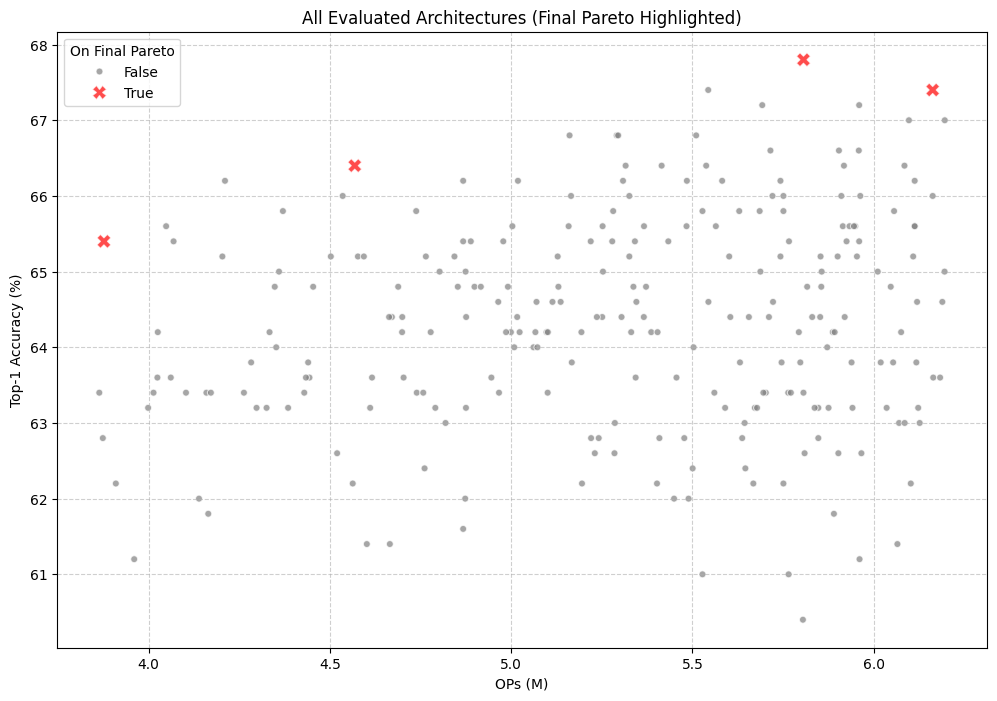

In [3]:
if not df_all_plot.empty:
    plt.figure(figsize=(12, 8))
    if 'on_final_pareto' in df_all_plot.columns and df_all_plot['on_final_pareto'].isin([True, False]).all():
        sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', hue='on_final_pareto',
                        palette={True: 'red', False: 'grey'}, style='on_final_pareto', 
                        markers={True: 'X', False: '.'}, s=100 if any(df_all_plot['on_final_pareto']) else 70, # Make Pareto points bigger
                        alpha=0.7)
        plt.legend(title='On Final Pareto')
    else:
        print("Warning: 'on_final_pareto' column issue. Plotting all points uniformly.")
        sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', color='grey', s=50, alpha=0.7)
    
    plt.title('All Evaluated Architectures (Final Pareto Highlighted)')
    plt.xlabel('OPs (M)')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("No data from vis_dict to plot the scatter of all evaluated architectures.")

### Table of Pareto Optimal Architectures

Details of the architectures found on the Pareto front.

In [4]:
if not df_final_pareto_table.empty:
    print("\n--- Final Architectures on the Pareto Front ---")
    with pd.option_context('display.max_colwidth', None, 'display.width', 1000):
        display(df_final_pareto_table[['OPs_Bucket_Key', 'OPs (M)', 'Accuracy (%)', 'Architecture']])
else:
    print("Final Pareto front table is empty or could not be generated.")


--- Final Architectures on the Pareto Front ---


,OPs_Bucket_Key,OPs (M),Accuracy (%),Architecture
0,3,3.876866,65.4,"(0, 0, 32, 3, 1, 1, 1, 0, 64, 5, 1, 1, -1, -1, 128, 5, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 5, 1, 1, -1, -1, 192, 5, 1, 1, 3, 0, 256, 3, 1, 2, 3, 1, 384, 3, 2, 1, -1, -1, 512, 5, 1, 1, -1, -1, 512, 3, 2, 1, 4, 0, 512, 3, 4, 2, 4, 1, 512, 3, 4, 2, -1, -1, 1024, 3, 4, 1, -1, -1, 1024, 3, 2, 1)"
1,4,4.568578,66.4,"(0, 0, 48, 3, 1, 1, 1, 0, 64, 3, 1, 1, -1, -1, 128, 5, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 192, 5, 1, 1, -1, -1, 192, 5, 1, 1, 3, 0, 256, 3, 1, 2, 3, 1, 256, 3, 2, 1, -1, -1, 384, 5, 1, 1, -1, -1, 512, 3, 2, 1, 4, 0, 512, 5, 4, 2, 4, 1, 768, 5, 4, 1, -1, -1, 1024, 3, 4, 1, -1, -1, 1024, 3, 2, 2)"
2,5,5.806082,67.8,"(0, 0, 48, 5, 1, 1, 1, 0, 64, 5, 1, 1, -1, -1, 128, 5, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 5, 1, 1, -1, -1, 192, 5, 1, 1, 3, 0, 256, 3, 1, 2, 3, 1, 384, 3, 2, 1, -1, -1, 512, 5, 1, 1, -1, -1, 512, 3, 2, 1, 4, 0, 512, 3, 4, 2, 4, 1, 512, 3, 4, 2, -1, -1, 1024, 3, 4, 1, -1, -1, 1024, 3, 2, 1)"
3,6,6.162434,67.4,"(0, 0, 48, 5, 1, 1, 1, 0, 64, 3, 1, 1, -1, -1, 64, 5, 1, 1, 2, 0, 128, 5, 2, 1, 2, 1, 192, 5, 1, 1, -1, -1, 192, 3, 1, 1, 3, 0, 256, 3, 1, 2, 3, 1, 256, 3, 2, 1, -1, -1, 384, 3, 1, 1, -1, -1, 384, 3, 2, 1, 4, 0, 768, 5, 4, 2, 4, 1, 1024, 5, 4, 1, -1, -1, 1024, 3, 4, 1, -1, -1, 1024, 3, 2, 2)"


### Fine-tuning Performance Comparison
Comparison of accuracy before and after fine-tuning for selected architectures.

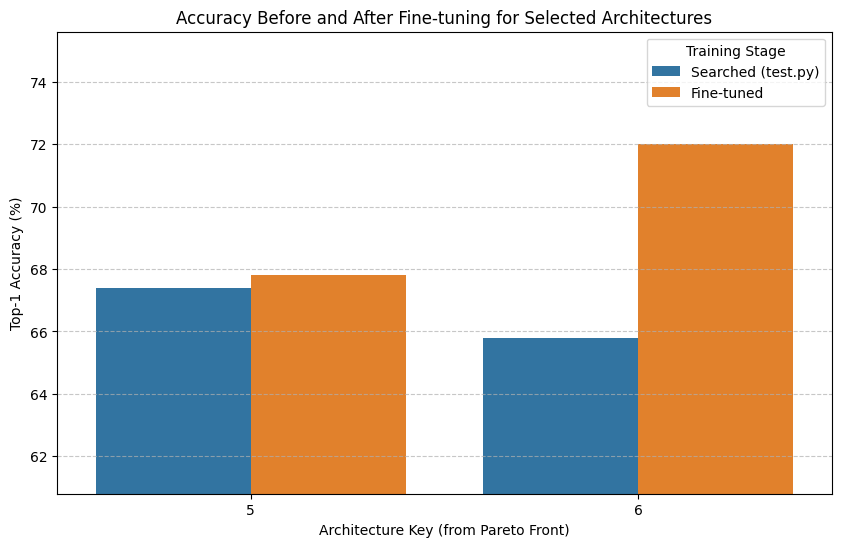

In [5]:
if not df_comparison.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_comparison, x='Key', y='Top-1 Acc (%)', hue='Stage')
    plt.title('Accuracy Before and After Fine-tuning for Selected Architectures')
    plt.xlabel('Architecture Key (from Pareto Front)')
    plt.ylabel('Top-1 Accuracy (%)')
    # Ensure y_min is not greater than y_max if all accuracies are 0 or None
    y_min_plot = 0
    if not df_comparison['Top-1 Acc (%)'].dropna().empty:
        y_min_plot = max(0, df_comparison['Top-1 Acc (%)'].dropna().min() - 5)
    plt.ylim(bottom=y_min_plot) 
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.legend(title='Training Stage')
    plt.show()
else:
    print("No comparison data to plot for fine-tuning improvement.")

## Step 6: Model Export to ONNX for Visualization

This section demonstrates how to export one of the fine-tuned models to ONNX format for visualization with tools like [Netron](https://netron.app/).

In [6]:
# In your ONNX Export Jupyter Cell (run_all.ipynb)

import torch
import torch.onnx
import os
import models
from models._utils import set_onnx_exporting
import numpy as np

print("--- Preparing ONNX Export ---")

# Choose which model to export (using the first tested key)
export_ops_key = ops_key_to_test1

# Define paths
finetuned_model_checkpoint_path = os.path.join(base_work_dir, f"finetuned_ops_key{export_ops_key}", "checkpoint.pth.tar")
onnx_filename = f"nasbnn_{dataset_name}_finetuned_ops_key{export_ops_key}.onnx"
onnx_output_path = os.path.join(base_work_dir, "onnx_exports")
os.makedirs(onnx_output_path, exist_ok=True)
full_onnx_path = os.path.join(onnx_output_path, onnx_filename)

print(f"Target ONNX file: {full_onnx_path}")

model_to_export = None
loaded_successfully = False

try:
    print(f"Loading architecture definition for key {export_ops_key} from {search_info_file}...")
    
    if not os.path.exists(search_info_file):
        raise FileNotFoundError(f"Search info file not found: {search_info_file}")
    
    search_results = torch.load(search_info_file, map_location='cpu')
    pareto_global = search_results.get('pareto_global', {}) 
    
    if export_ops_key not in pareto_global:
        raise ValueError(f"OPs Key {export_ops_key} not found in Pareto front. Available keys: {list(pareto_global.keys())}")
    
    arch_tuple_flat_from_search = pareto_global[export_ops_key] 
    print(f"Loaded architecture tuple: {arch_tuple_flat_from_search}")

    # Reshape flat architecture tuple to structured format
    if len(arch_tuple_flat_from_search) % 6 != 0:
        raise ValueError(f"Architecture tuple length {len(arch_tuple_flat_from_search)} is not divisible by 6")

    structured_arch_list = []
    for i in range(0, len(arch_tuple_flat_from_search), 6):
        block_config = arch_tuple_flat_from_search[i:i+6]
        tensor_block = [torch.tensor(val, dtype=torch.long) for val in block_config]
        structured_arch_list.append(tensor_block)
    
    print(f"Reshaped architecture (blocks: {len(structured_arch_list)})")

    # Instantiate and configure model
    model_to_export = models.__dict__[architecture_name]() 
    model_to_export.eval() 

    # Create dummy input
    if dataset_name == 'cifar10': 
        dummy_input_shape = (1, 3, 32, 32) 
    elif dataset_name == 'imagenet': 
        dummy_input_shape = (1, 3, 224, 224) 
    elif dataset_name == 'WakeVision': 
        dummy_input_shape = (1, 3, wakevision_img_size, wakevision_img_size)
    else: 
        raise ValueError(f"Unknown dataset '{dataset_name}' for dummy input shape")
    
    dummy_input_cpu = torch.randn(dummy_input_shape, dtype=torch.float32)
    
    print("Converting model to static architecture...")
    if hasattr(model_to_export, 'to_static'):
        model_to_export.to_static(dummy_input_cpu, sub_path_tuples=structured_arch_list)
        print("Model converted to static architecture successfully.")
    else:
        raise AttributeError(f"Model {architecture_name} does not have a to_static method")

    # Load fine-tuned weights
    print(f"Loading fine-tuned weights from: {finetuned_model_checkpoint_path}")
    if not os.path.exists(finetuned_model_checkpoint_path):
        raise FileNotFoundError(f"Model checkpoint not found: {finetuned_model_checkpoint_path}")
        
    checkpoint = torch.load(finetuned_model_checkpoint_path, map_location='cpu')
    state_dict = checkpoint['state_dict']
    
    # Remove 'module.' prefix if present
    new_state_dict = {(k[7:] if k.startswith('module.') else k): v for k, v in state_dict.items()}
    
    model_to_export.load_state_dict(new_state_dict, strict=True)
    print("Fine-tuned weights loaded successfully.")
    loaded_successfully = True

except Exception as e:
    print(f"ERROR during model preparation: {e}")
    import traceback
    traceback.print_exc()
    loaded_successfully = False

# Export to ONNX
if loaded_successfully and model_to_export:
    try:
        print(f"Exporting model to ONNX...")
        
        dummy_input_for_onnx = torch.randn(dummy_input_shape, device='cpu', dtype=torch.float32)
        input_names = ["input_image"]
        output_names = ["output_predictions"] 

        set_onnx_exporting(True) 
        
        torch.onnx.export(
            model_to_export,
            dummy_input_for_onnx,
            full_onnx_path,
            input_names=input_names,
            output_names=output_names,
            opset_version=12, 
            verbose=False
        )
        
        print(f"✅ Model successfully exported to ONNX: {full_onnx_path}")
        print("📊 You can now visualize this .onnx file with Netron at https://netron.app/")
        
    except Exception as e:
        print(f"ERROR during ONNX export: {e}")
        import traceback
        traceback.print_exc() 
    finally:
        set_onnx_exporting(False) 
else:
    print("❌ Model preparation failed, skipping ONNX export.")

ImportError: cannot import name 'set_onnx_exporting' from 'models._utils' (c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test09\models\_utils.py)

## 🎉 Pipeline Complete!

**Congratulations!** You have successfully executed the complete NAS-BNN pipeline for **WakeVision person detection**.

### 📂 **Results Overview:**
- **Supernet Training**: `{base_work_dir}/train.log`
- **Architecture Search**: `{search_output_dir}/info.pth.tar`
- **Testing Results**: `{search_output_dir}/test_ops_key*/test.log`
- **Fine-tuning Results**: `{base_work_dir}/finetuned_ops_key*/train.log`
- **ONNX Models**: `{base_work_dir}/onnx_exports/`

### ✅ **Pipeline Achievements:**
1. **Data Preparation** - Processed WakeVision dataset for person detection
2. **Supernet Training** - Trained the supernet across all possible architectures
3. **Architecture Search** - Discovered Pareto-optimal architectures via evolutionary search
4. **Performance Testing** - Evaluated selected architectures from search results
5. **Fine-tuning** - Improved performance of selected architectures
6. **Analysis & Visualization** - Generated comprehensive performance analysis
7. **Model Export** - Exported models to ONNX format for deployment/visualization

### 🚀 **Next Steps:**
- **Deploy Models**: Use ONNX exports for edge inference applications
- **Experiment Further**: Try different OPs ranges or search parameters
- **Extend to New Datasets**: Adapt the pipeline for other computer vision tasks
- **Contribute**: Share improvements with the NAS-BNN community

### 🔗 **Key Features Demonstrated:**
- Multi-dataset adaptation (ImageNet → CIFAR-10 → WakeVision)
- Hardware-aware neural architecture search
- Automated pipeline execution with comprehensive analysis
- Model export for production deployment